In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Install library `jcopml`

J.COp ML is a machine Learning package to complement scikit-learn workflow. It includes helper functions for visualization, tuning, pipeline, and feature importance.

Link: https://pypi.org/project/jcopml/

In [2]:
! pip install jcopml

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model
from jcopml.plot import plot_actual_vs_prediction, plot_missing_value
from jcopml.automl import AutoRegressor
from jcopml.tuning import random_search_params as rsp

In [4]:
# Upload dataset train and test
uploaded = files.upload()

Saving train.csv to train (1).csv


In [5]:
uploaded = files.upload()

Saving test.csv to test (1).csv


# Data Input

In [6]:
# Common Functions

# Check shape of train and test data
def df_shape(df_train, df_test):
  print(f'Train shape: {df_train.shape} \t Test shape: {df_test.shape}')

In [7]:
house_train = pd.read_csv('train.csv')
house_test = pd.read_csv('test.csv')
df_shape(house_train, house_test)

Train shape: (1460, 81) 	 Test shape: (1459, 80)


We try to concat the data into one dataframe and fix the problem like outliers and missing values for the next step

In [8]:
# Try to separate Id column
house_train_Id = house_train.Id
house_test_Id = house_test.Id

# Drop column Id
house_train.drop(columns='Id', inplace=True)
house_test.drop(columns='Id', inplace=True)
df_shape(house_train, house_test)

Train shape: (1460, 80) 	 Test shape: (1459, 79)


# Preprocessing

In [9]:
# Common Functions

def plot_outliers(df, feature, target):
  fig, ax = plt.subplots()
  ax.scatter(x = df[feature], y = df[target])
  plt.ylabel(target, fontsize=13)
  plt.xlabel(feature, fontsize=13)
  plt.show()

def plot_distribution_qq(df, target):
  sns.distplot(df[target] , fit=norm);
  
  # Get the fitted parameters used by the function
  (mu, sigma) = norm.fit(df[target])

  # Now plot the distribution
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
  plt.ylabel('Frequency')
  plt.title(f'{target} distribution')

  # Get also the QQ-plot
  fig = plt.figure()
  res = stats.probplot(df[target], plot=plt)
  plt.show()

def plot_box(df):
  f, ax = plt.subplots(figsize=(15, 12))
  plt.xticks(rotation='90')
  sns.barplot(x=df.index, y=df)
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)

def plot_correlation(corr):
  plt.subplots(figsize=(12,9))
  sns.heatmap(corr, vmax=0.9, square=True)

def fill_na(df, feature, data):
  df[feature] = df[feature].fillna(data)

def percentage_missing(df):
  percentage = df.isna().sum() / len(df) * 100
  return percentage.drop(percentage[percentage == 0].index).sort_values(ascending=False)

### Outliers

Ames Housing Data indicates that there are outliers present in the training data. 

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

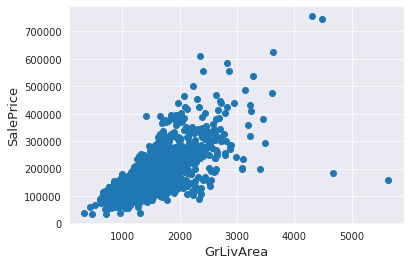

In [10]:
plot_outliers(house_train, 'GrLivArea', 'SalePrice')

We can see that there are two points GrLivArea at low price (more than 4000 and below 300000. Then, try to delete them

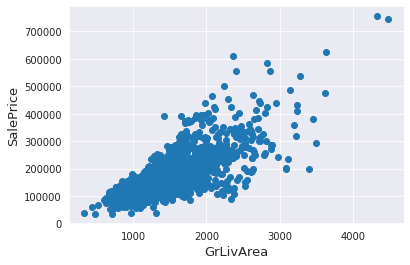

In [11]:
# Delete outliers and check plot again
house_train = house_train.drop(
    house_train[(house_train['GrLivArea']>4000) & (house_train['SalePrice']<300000)].index
)
plot_outliers(house_train, 'GrLivArea', 'SalePrice')

Target Value, we want to check the distribution of the data. Is there any skewness or not

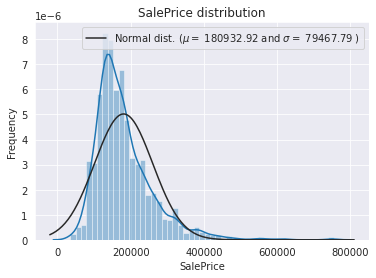

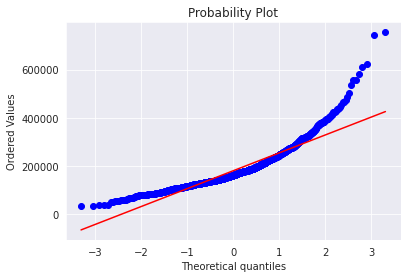

In [12]:
plot_distribution_qq(house_train, 'SalePrice')

The result shows that the target value is right skewed, so we need to transform and make it normally distribution

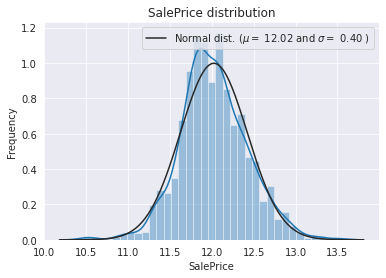

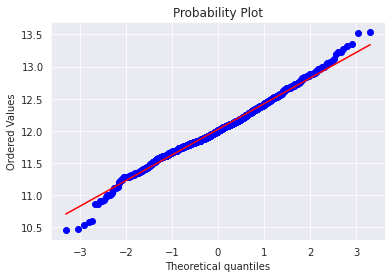

In [13]:
# Try to transform using numpy fuction log1p which  applies log(1+x) to all elements of the column
house_train["SalePrice"] = np.log1p(house_train["SalePrice"])

# Show the distribution again
plot_distribution_qq(house_train, 'SalePrice')

Okay, looks good that the data now is normally distrbuted. Let get some coffee. :)

Concat train and test data

In [14]:
# Concat all data from house_train and house_test

# Save n data for each dataset
n_train = house_train.shape[0]
n_test = house_test.shape[0]

# Take SalePrice
y_train = house_train.SalePrice.values

# Concat
house_all = pd.concat((house_train, house_test)).reset_index(drop=True)
house_all.drop(['SalePrice'], axis=1, inplace=True)

print(f'house_all shape: {house_all.shape}')

house_all shape: (2917, 79)


### Missing Values

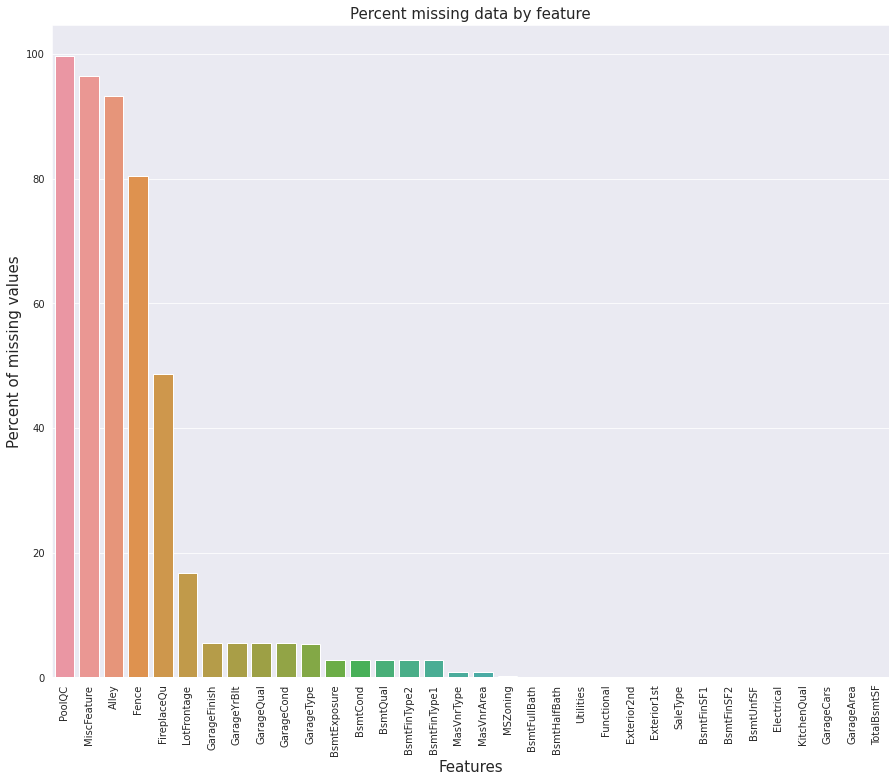

In [15]:
# Calculate the percentation missing values
percent_missing_all = percentage_missing(house_all)
plot_box(percent_missing_all)

After we know which features have missing values, then, try to impute base on information we got from description

**PoolQC** : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

**MiscFeature** : data description says NA means "no misc feature"

**Alley** : data description says NA means "no alley access"

**Fence** : data description says NA means "no fence"

**FireplaceQu** : data description says NA means "no fireplace"

**LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can *fill in missing values by the median* **LotFrontage** of the neighborhood.

**GarageType**, **GarageFinish**, **GarageQual**, and **GarageCond** : Replacing missing data with None

**GarageYrBlt**, **GarageArea**, and **GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

**BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **BsmtFullBath**, and **BsmtHalfBath** : missing values are likely zero for having no basement

**BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1**, and **BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no basement.

**MasVnrArea** and **MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

**MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

**Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

**Functional** : data description says NA means typical

**Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

**KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

**Exterior1st** and **Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

**SaleType** : Fill in again with most frequent which is "WD"

**MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [16]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
  fill_na(house_all, col, 'None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
  fill_na(house_all, col, 0)

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
  fill_na(house_all, col, house_all[col].mode()[0])

fill_na(house_all, 'Functional', 'Typ')

# Median
house_all['LotFrontage'] = house_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Drop
house_all = house_all.drop(['Utilities'], axis=1)

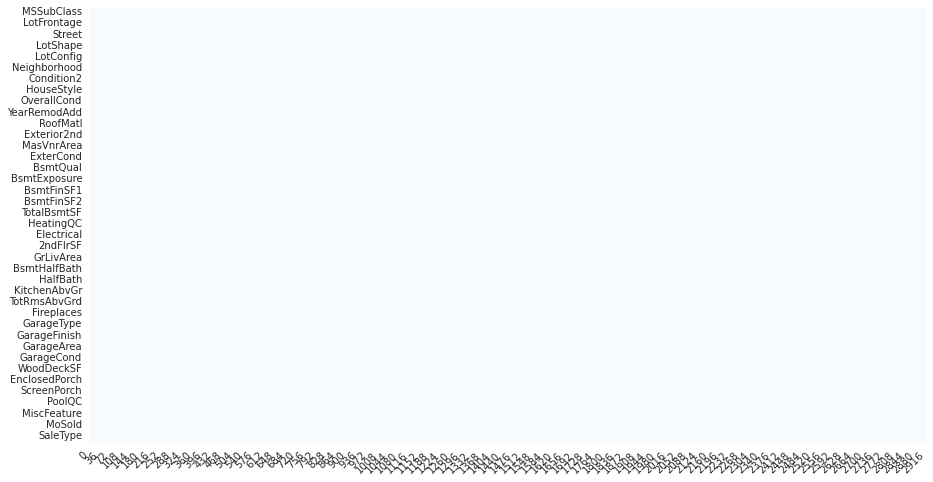

In [17]:
plot_missing_value(house_all)

In [18]:
print(f'house_all shape: {house_all.shape}')

house_all shape: (2917, 78)


### Numerical Features to Categorical Features

Some features need to change to categorical data
`MSSubClass, OverallCond, YrSold, MoSold` because it may have no meaning in numerical values

In [19]:
def num_to_cat(df, feature):
  df[feature] = df[feature].apply(str)

def num_cat_list(df):
  list_num, list_cat = df.select_dtypes(exclude='object').columns.tolist(), df.select_dtypes(include='object').columns.tolist()
  return list_num, list_cat

In [20]:
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
  num_to_cat(house_all, col)

house_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


### Skewness of Features

In [23]:
def skew_list(df):
  list_num, list_cat = num_cat_list(df)
  df_skews = df[list_num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  print('\nSkewness for numeric features: \n')
  skewness = pd.DataFrame({'Skewness' : df_skews})
  return skewness

def skew_box_cox(df, skews, lamda=0.15):
  from scipy.special import boxcox1p

  skewed_features = skews.index
  for feat in skewed_features:
      df[feat] = boxcox1p(df[feat], lamda)
  return df

In [24]:
# Show the skewness
skewness = skew_list(house_all)
skewness.head(10)


Skewness for numeric features: 



,Skewness
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


Then, we try to handle the skewness with threshold 0.75 using Box-Cox

We use the scipy function boxcox1p which computes the Box-Cox transformation of `1+x`.

Note that setting `λ=0` is equivalent to `log1p` used above for the target variable.

http://onlinestatbook.com/2/transformations/box-cox.html

In [25]:
skewness = skewness[abs(skewness) > 0.75]
print(f'Number of numerical features that need to handle for the skewness: {skewness.shape[0]}')

Number of numerical features that need to handle for the skewness: 32


In [26]:
house_all = skew_box_cox(house_all, skewness)

### Data Splitting

Before next step, modelling, we should separate again between training data and test data

In [27]:
X_train = house_all[:n_train]
X_test = house_all[n_train:]

df_shape(X_train, X_test)
print(f'y_train: {y_train.shape}')

Train shape: (1458, 78) 	 Test shape: (1459, 78)
y_train: (1458,)


# Modelling

In [28]:
list_num, list_cat = num_cat_list(X_train)

### Auto ML

The model will find `Best Model` from all possible algorithms

In [29]:
model = AutoRegressor(list_num, list_cat, random_state=42)
model.fit(X_train, y_train, cv=5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.3min finished


================== Best Model Info ==================
algo                      | ElasticNet
algo__alpha               | 0.0002800940363375679
algo__fit_intercept       | True
algo__l1_ratio            | 0.42340148070636974

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=True, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
numerical_imputer         | KNNImputer(add_indicator=False, n_neighbors=5)

=========== Score ===========
Train: 0.9522930256770241
Valid: 0.9061947953981437
Test : 0.9235721439059299


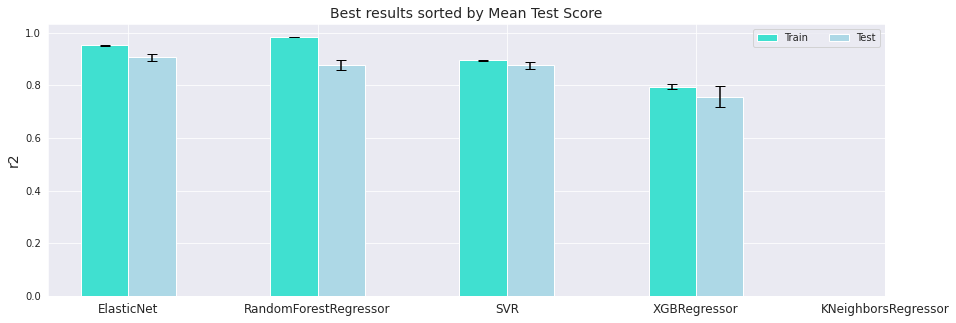

In [30]:
model.plot_results()

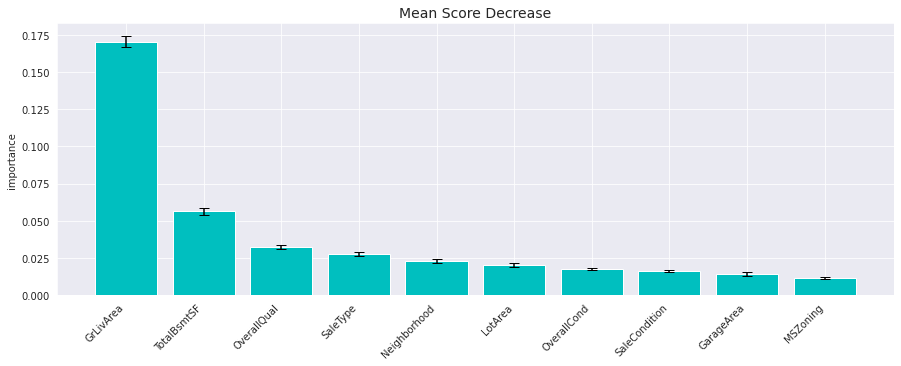

In [31]:
model.mean_score_decrease()

In [32]:
y_pred_eln = model.predict(X_test)

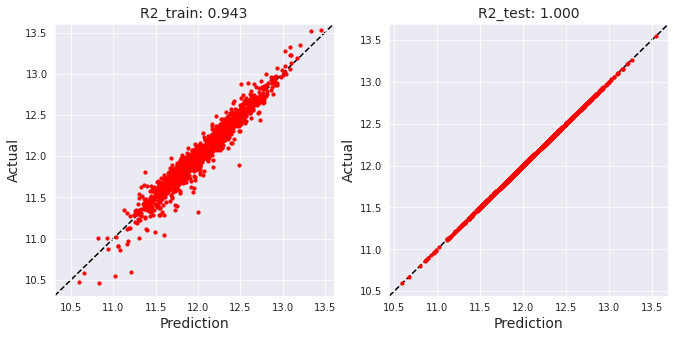

In [33]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_pred_eln, model)

In [34]:
# Save Model
save_model(model, 'house_pricing_automl__v2.pkl')

Model is pickled as model/house_pricing_automl__v2.pkl


### Random Forest

Using Random Forest Regressor to predict

In [35]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(impute='knn'), list_num),
    ('categoric', cat_pipe(encoder='onehot'), list_cat)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_rf_rsp = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_rf_rsp.fit(X_train, y_train)

y_pred_rf = model_rf_rsp.predict(X_test)

print(model_rf_rsp.best_params_)
print(model_rf_rsp.score(X_train, y_train), model_rf_rsp.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.9min finished


{'algo': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=26, max_features=0.4810613326357327,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=107, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False), 'algo__max_depth': 26, 'algo__max_features': 0.4810613326357327, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 107, 'prep__categoric': Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('onehot',
                 OneHotEncoder(categories='auto

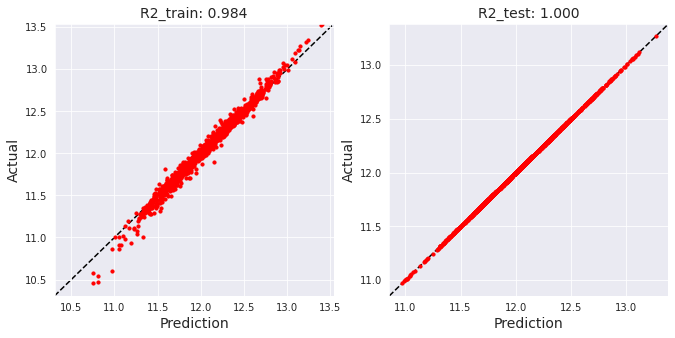

In [36]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_pred_rf, model_rf_rsp)

In [37]:
# Save Model
save_model(model_rf_rsp, 'house_pricing_rf__v2.pkl')

Model is pickled as model/house_pricing_rf__v2.pkl


### Gradient Boosting

Using XGB Regressor to predict

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(impute='knn'), list_num),
    ('categoric', cat_pipe(encoder='onehot'), list_cat)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model_xgb_rsp = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_xgb_rsp.fit(X_train, y_train)

y_pred_xgb = model_xgb_rsp.predict(X_test)

print(model_xgb_rsp.best_params_)
print(model_xgb_rsp.score(X_train, y_train), model_xgb_rsp.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


[09:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6056800229293963, gamma=1,
             importance_type='gain', learning_rate=0.22892306913942886,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=188, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0.008973143427684457,
             reg_lambda=0.03242765506149092, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5671637367652818, verbosity=1), 'algo__colsample_bytree': 0.6056800229293963, 'algo__gamma': 1, 'algo__learning_rate': 0.22892306913942886, 'algo__max_depth': 7, 'algo__n_estimators': 188, 'algo__reg_alpha': 0.008973143427684457, 'algo__reg_lambda': 0.03242765506149092, 'algo__subsample': 0.5671637367652818, '

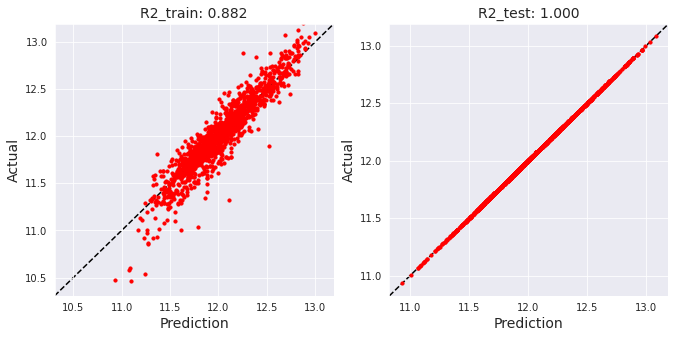

In [39]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_pred_xgb, model_xgb_rsp)

In [40]:
# Save Model
save_model(model_xgb_rsp, 'house_pricing_xgb__v2.pkl')

Model is pickled as model/house_pricing_xgb__v2.pkl


# Submission

In [41]:
def submit(y_pred, filename='submission__v1.csv'):
  sub = pd.DataFrame()
  sub['Id'] = house_test_Id
  sub['SalePrice'] = np.expm1(y_pred)
  sub.to_csv(filename, index=False)

In [42]:
submit(y_pred_eln, 'automl_esn__v1.csv')
submit(y_pred_rf, 'rf__v2.csv')
submit(y_pred_xgb, 'xgb__v3.csv')